# Interaction between mock, CV, and novel taxa results
The purpose of this notebook is to plot the F-measure (or other metric) scores achieved for mock community, cross-validated, and novel taxa evaluations with each method/parameter configuration. Each configuration that is tested in all three evaluations will be plotted in 3D space as a single point (averaged across all datasets/samples, e.g., all samples in each mock community will be averaged since the same samples do not exist in the cv and nt evals).

First we load modules and data.

In [1]:
from os.path import join, expandvars
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.xkcd_rgb as colors
from mpl_toolkits.mplot3d import Axes3D
from tax_credit.plotting_functions import isolate_top_params
#%matplotlib notebook
%matplotlib inline


In [2]:
project_dir = expandvars("../../")
precomputed_results = join(project_dir, "data", "precomputed-results")
mock_results = pd.DataFrame.from_csv(join(
    precomputed_results, "mock-community", "mock_results.tsv"), sep="\t")
cv_results = pd.DataFrame.from_csv(join(
    precomputed_results, "cross-validated", "evaluate_classification_summary.csv"))
nt_results = pd.DataFrame.from_csv(join(
    precomputed_results, "novel-taxa-simulations", "evaluate_classification_summary.csv"))

# we can save plots in this directory
outdir = expandvars("../../../plots/")

We can set some global variables here

In [3]:
level = 6
metric = "F-measure"
method = "Method"
params = "Parameters"
reference = "Reference"
dataset = "Dataset"

color_palette={
    'rdp': colors['baby shit green'], 'sortmerna': colors['macaroni and cheese'],
    'uclust': 'coral', 'blast': 'indigo', 'blast+': colors['electric purple'], 'naive-bayes': 'dodgerblue',
    'naive-bayes-bespoke': 'blue', 'vsearch': 'firebrick'
}



We will use the following functions for combining evaluations and plotting

In [4]:
def combined_evaluation(mock_results, cv_results, nt_results, params, metric, method, reference, dataset, domain, level):
    pd.options.mode.chained_assignment = None  # default='warn'

    # Filter mock results to use correct datasets
    dataset_ids = ['mock-1', 'mock-2', 'mock-3', 'mock-4', 'mock-5', 'mock-7', 'mock-8', 'mock-9',
                   'mock-10', 'mock-12', 'mock-16', 'mock-18', 'mock-19', 'mock-20', 'mock-21', 
                   'mock-22', 'mock-23', 'mock-24', 'mock-26-ITS1', 'mock-26-ITS9']
    method_ids = ['rdp', 'sortmerna', 'uclust', 'blast', 'blast+', 'naive-bayes', 'naive-bayes-bespoke', 'vsearch']
    if domain == "fungi":
        ref_ids = ['F1-REF', 'F2-REF', 'F3-REF', 'unite_20.11.2016_clean_fullITS']
    elif domain == "bacteria":
        ref_ids = ['B1-REF', 'B2-REF', 'B3-REF', 'gg_13_8_otus']
    # otherwise combine bacteria and fungi
    else:
        ref_ids = ['B1-REF', 'B2-REF', 'B3-REF', 'gg_13_8_otus', 'F1-REF', 'F2-REF', 'F3-REF', 'unite_20.11.2016_clean_fullITS']

    # Set level
    mock_results = mock_results[mock_results['Level'] == level]
    nt_results = nt_results[nt_results['level'] == level]
    
    # Filter mock results to use correct datasets
    mock_results = mock_results[(mock_results[reference].isin(ref_ids)) & 
                                (mock_results[method].isin(method_ids)) &
                                (mock_results[dataset].isin(dataset_ids))]

    # Filter nt and cv results to use correct datasets
    cv_results = cv_results[cv_results[dataset].isin(ref_ids)]
    nt_results = nt_results[nt_results[dataset].isin(ref_ids)]

    # modify parameter names so all evaluations use same conventions
    mock_results[params] = mock_results[params].str.replace('prior:char:8192','')
    mock_results[params] = mock_results[params].str.replace('char:8192:','')

    # extract per-level results from cv_results
    for m in ['Precision', 'Recall', 'F-measure']:
        level_results = []
        for v in cv_results[m]:
            v = v.strip('[]').split(', ')
            level_results.append(float(v[level]))
        cv_results[m] = level_results

    # join all eval dataframes into one
    mock_mean = mock_results.groupby([method, params]).mean()
    cv_mean = cv_results.groupby([method, params]).mean()
    nt_mean = nt_results.groupby([method, params]).mean()
    dat = ['F-measure', 'Precision', 'Recall']
    evals_combined  = pd.concat([mock_mean[dat], cv_mean[dat], nt_mean[dat]], axis=1, join='inner')
    evals_combined.columns = ['Mock', 'MP', 'MR', 'Cross-validated', 'CP', 'CR', 'Novel taxa', 'NP', 'NR']
    
    return evals_combined


def plot_3d(evals_combined, x='Mock', y='Cross-validated', z='Novel taxa'):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_facecolor('white')
    for m in evals_combined.index.levels[0]:
        evals_subset = evals_combined.loc[m]
        ax.scatter(xs=evals_subset[x],
                   ys=evals_subset[y],
                   zs=evals_subset[z],
                   c=color_palette[m])

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    plt.show()
    
    return ax


def set_threshold(df, mock_threshold, cv_threshold, nt_threshold, x='Mock', y='Cross-validated', z='Novel taxa'):
    mock_threshold = df[x] >= mock_threshold
    cv_threshold = df[y] >= cv_threshold
    nt_threshold = df[z] >= nt_threshold
    df = df[mock_threshold & cv_threshold & nt_threshold]
    return df


## Bacteria level 5

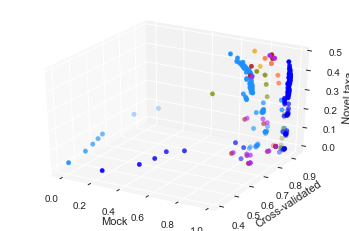

In [167]:
evals_bacteria_5 = combined_evaluation(
    mock_results, cv_results, nt_results, params,
    metric, method, reference, dataset, "bacteria", 5)

ax = plot_3d(evals_bacteria_5)

ax.get_figure().savefig(join(outdir, "3way-eval-fmeasure-bacteria-genus.pdf"), facecolor="white")
ax.get_figure().savefig(join(outdir, "3way-eval-fmeasure-bacteria-genus.png"), facecolor="white")


In [169]:
# find top-performing methods across all evals
evals_bacteria_5['sum'] = evals_bacteria_5['Mock'] + evals_bacteria_5['Cross-validated'] + evals_bacteria_5['Novel taxa']
evals_bacteria_5.sort_values('sum', ascending=False)[:10]


Mock        MP        MR  \
Method              Parameters                                          
naive-bayes-bespoke 0.001::[6,6]:0.98    0.970689  0.989877  0.953833   
                    0.001::[6,6]:0.96    0.971723  0.986793  0.958080   
                    0.001::[7,7]:0.98    0.972685  0.986276  0.960380   
                    0.001::[8,8]:0.98    0.973107  0.982298  0.964539   
                    0.001::[6,6]:0.94    0.974508  0.986894  0.963113   
                    0.001::[9,9]:0.98    0.974424  0.982298  0.967079   
                    0.001::[7,7]:0.96    0.974684  0.986080  0.964122   
                    0.001::[10,10]:0.98  0.974372  0.982193  0.967079   
                    0.001::[6,6]:0.92    0.975427  0.986885  0.964901   
                    0.001::[7,7]:0.94    0.976038  0.985353  0.967389   

                                         Cross-validated        CP        CR  \
Method              Parameters                                                 
naive-bayes-bespoke 0.001::[6,6]:0.98           0.916163  0.980870  0.859521   
                    0.001::[6,6]:0.96           0.921763  0.977041  0.872439   
                    0.001::[7,7]:0.98           0.922175  0.979056  0.871577   
                    0.001::[8,8]:0.98           0.921779  0.977143  0.872374   
                    0.001::[6,6]:0.94           0.924388  0.974047  0.879582   
                    0.001::[9,9]:0.98           0.921708  0.976683  0.872626   
                    0.001::[7,7]:0.96           0.925577  0.974581  0.881297   
                    0.001::[10,10]:0.98         0.920799  0.975124  0.872233   
                    0.001::[6,6]:0.92           0.926120  0.971784  0.884580   
                    0.001::[7,7]:0.94           0.928345  0.972249  0.888259   

                                         Novel taxa        NP        NR  \
Method              Parameters                                            
naive-bayes-bespoke 0.001::[6,6]:0.98      0.455828  0.628098  0.357821   
                    0.001::[6,6]:0.96      0.433962  0.571083  0.350050   
                    0.001::[7,7]:0.98      0.420981  0.562312  0.336577   
                    0.001::[8,8]:0.98      0.418760  0.551287  0.337727   
                    0.001::[6,6]:0.94      0.412691  0.531172  0.337529   
                    0.001::[9,9]:0.98      0.409537  0.534702  0.331941   
                    0.001::[7,7]:0.96      0.403508  0.519721  0.329923   
                    0.001::[10,10]:0.98    0.397393  0.517350  0.322680   
                    0.001::[6,6]:0.92      0.390122  0.492246  0.323184   
                    0.001::[7,7]:0.94      0.385949  0.486296  0.320042   

                                              sum  
Method              Parameters                     
naive-bayes-bespoke 0.001::[6,6]:0.98    2.342680  
                    0.001::[6,6]:0.96    2.327448  
                    0.001::[7,7]:0.98    2.315841  
                    0.001::[8,8]:0.98    2.313646  
                    0.001::[6,6]:0.94    2.311587  
                    0.001::[9,9]:0.98    2.305669  
                    0.001::[7,7]:0.96    2.303769  
                    0.001::[10,10]:0.98  2.292564  
                    0.001::[6,6]:0.92    2.291669  
                    0.001::[7,7]:0.94    2.290332

## Bacteria level 6

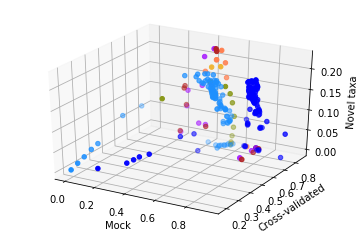

In [5]:
evals_bacteria = combined_evaluation(
    mock_results, cv_results, nt_results, params,
    metric, method, reference, dataset, "bacteria", level)

ax = plot_3d(evals_bacteria)

ax.get_figure().savefig(join(outdir, "3way-eval-fmeasure-bacteria.pdf"), facecolor="white")
ax.get_figure().savefig(join(outdir, "3way-eval-fmeasure-bacteria.png"), facecolor="white")


#### Top method: sum of metrics

In [172]:
# find top-performing methods across all evals
evals_bacteria['sum'] = evals_bacteria['Mock'] + evals_bacteria['Cross-validated'] + evals_bacteria['Novel taxa']
evals_bacteria.sort_values('sum', ascending=False)[:10]


Mock        MP        MR  \
Method              Parameters                                         
naive-bayes-bespoke 0.001::[32,32]:0.5  0.936868  0.966365  0.913330   
                    0.001::[6,6]:0.9    0.705332  0.979879  0.581917   
                    0.001::[7,7]:0.9    0.714312  0.978454  0.593650   
                    0.001::[7,7]:0.92   0.712372  0.978162  0.591565   
                    0.001::[7,7]:0.94   0.708118  0.977916  0.585749   
                    0.001::[6,6]:0.92   0.704833  0.979810  0.581093   
                    0.001::[32,32]:0.0  0.936223  0.964806  0.913330   
                    0.001::[8,8]:0.92   0.711734  0.974683  0.592544   
                    0.001::[6,6]:0.94   0.703041  0.979805  0.578943   
                    0.001::[8,8]:0.94   0.711090  0.974684  0.591729   

                                        Cross-validated        CP        CR  \
Method              Parameters                                                
naive-bayes-bespoke 0.001::[32,32]:0.5         0.787882  0.817525  0.760322   
                    0.001::[6,6]:0.9           0.826988  0.931062  0.743872   
                    0.001::[7,7]:0.9           0.832648  0.925569  0.756722   
                    0.001::[7,7]:0.92          0.831132  0.930816  0.750772   
                    0.001::[7,7]:0.94          0.828505  0.936003  0.743191   
                    0.001::[6,6]:0.92          0.824505  0.936172  0.736666   
                    0.001::[32,32]:0.0         0.756596  0.756634  0.756559   
                    0.001::[8,8]:0.92          0.829372  0.924433  0.752067   
                    0.001::[6,6]:0.94          0.821557  0.941725  0.728625   
                    0.001::[8,8]:0.94          0.827487  0.930286  0.745172   

                                        Novel taxa        NP        NR  \
Method              Parameters                                           
naive-bayes-bespoke 0.001::[32,32]:0.5    0.053593  0.066694  0.044801   
                    0.001::[6,6]:0.9      0.165107  0.242715  0.125204   
                    0.001::[7,7]:0.9      0.147954  0.209964  0.114300   
                    0.001::[7,7]:0.92     0.151371  0.221300  0.115118   
                    0.001::[7,7]:0.94     0.157324  0.238789  0.117408   
                    0.001::[6,6]:0.92     0.164581  0.250958  0.122554   
                    0.001::[32,32]:0.0    0.000000  0.000000  0.000000   
                    0.001::[8,8]:0.92     0.147249  0.212426  0.112743   
                    0.001::[6,6]:0.94     0.161884  0.258988  0.117844   
                    0.001::[8,8]:0.94     0.147354  0.219961  0.110847   

                                             sum  
Method              Parameters                    
naive-bayes-bespoke 0.001::[32,32]:0.5  1.778343  
                    0.001::[6,6]:0.9    1.697427  
                    0.001::[7,7]:0.9    1.694913  
                    0.001::[7,7]:0.92   1.694876  
                    0.001::[7,7]:0.94   1.693947  
                    0.001::[6,6]:0.92   1.693919  
                    0.001::[32,32]:0.0  1.692819  
                    0.001::[8,8]:0.92   1.688355  
                    0.001::[6,6]:0.94   1.686481  
                    0.001::[8,8]:0.94   1.685931

#### "Balanced" metric

In [39]:
devstats = set_threshold(evals_bacteria, 0.49, 0.8, 0.1)
devstats.drop('naive-bayes-bespoke', level='Method')

Mock        MP        MR  Cross-validated  \
Method      Parameters                                                       
naive-bayes 0.001:[7,7]:0.7  0.495098  0.796890  0.379857         0.819099   
rdp         0.6              0.564054  0.798071  0.457446         0.815074   
            0.7              0.549891  0.798858  0.438440         0.812072   
uclust      0.51:0.9:3       0.498087  0.746494  0.392272         0.845572   

                                   CP        CR  Novel taxa        NP  \
Method      Parameters                                                  
naive-bayes 0.001:[7,7]:0.7  0.886408  0.761298    0.115386  0.138005   
rdp         0.6              0.868454  0.767878    0.101518  0.127849   
            0.7              0.891594  0.745585    0.123523  0.172987   
uclust      0.51:0.9:3       0.875786  0.817389    0.154467  0.201026   

                                   NR  
Method      Parameters                 
naive-bayes 0.001:[7,7]:0.7  0.099164  
rdp         0.6              0.084196  
            0.7              0.096091  
uclust      0.51:0.9:3       0.125508

In [174]:
set_threshold(evals_bacteria, 0.7, 0.8, 0.15)

Mock        MP        MR  \
Method              Parameters                                        
naive-bayes-bespoke 0.001::[6,6]:0.9   0.705332  0.979879  0.581917   
                    0.001::[6,6]:0.92  0.704833  0.979810  0.581093   
                    0.001::[6,6]:0.94  0.703041  0.979805  0.578943   
                    0.001::[7,7]:0.92  0.712372  0.978162  0.591565   
                    0.001::[7,7]:0.94  0.708118  0.977916  0.585749   

                                       Cross-validated        CP        CR  \
Method              Parameters                                               
naive-bayes-bespoke 0.001::[6,6]:0.9          0.826988  0.931062  0.743872   
                    0.001::[6,6]:0.92         0.824505  0.936172  0.736666   
                    0.001::[6,6]:0.94         0.821557  0.941725  0.728625   
                    0.001::[7,7]:0.92         0.831132  0.930816  0.750772   
                    0.001::[7,7]:0.94         0.828505  0.936003  0.743191   

                                       Novel taxa        NP        NR  \
Method              Parameters                                          
naive-bayes-bespoke 0.001::[6,6]:0.9     0.165107  0.242715  0.125204   
                    0.001::[6,6]:0.92    0.164581  0.250958  0.122554   
                    0.001::[6,6]:0.94    0.161884  0.258988  0.117844   
                    0.001::[7,7]:0.92    0.151371  0.221300  0.115118   
                    0.001::[7,7]:0.94    0.157324  0.238789  0.117408   

                                            sum  
Method              Parameters                   
naive-bayes-bespoke 0.001::[6,6]:0.9   1.697427  
                    0.001::[6,6]:0.92  1.693919  
                    0.001::[6,6]:0.94  1.686481  
                    0.001::[7,7]:0.92  1.694876  
                    0.001::[7,7]:0.94  1.693947

#### "novel" method

In [175]:
set_threshold(evals_bacteria, 0.4, 0.8, 0.2)

Mock        MP        MR  Cross-validated  \
Method  Parameters                                                         
blast+  0.001:10:0.51:0.8  0.435585  0.723258  0.325427         0.816035   
uclust  0.76:0.9:5         0.467342  0.775436  0.347768         0.839738   
vsearch 10:0.51:0.8        0.449867  0.739803  0.341887         0.814357   
        10:0.51:0.9        0.450025  0.740312  0.341899         0.819837   

                                 CP        CR  Novel taxa        NP        NR  \
Method  Parameters                                                              
blast+  0.001:10:0.51:0.8  0.896382  0.749011    0.225072  0.331765  0.170688   
uclust  0.76:0.9:5         0.938376  0.759930    0.219491  0.357840  0.158487   
vsearch 10:0.51:0.8        0.891174  0.749787    0.225973  0.332746  0.171471   
        10:0.51:0.9        0.896329  0.755438    0.218961  0.337687  0.162389   

                                sum  
Method  Parameters                   
blast+  0.001:10:0.51:0.8  1.476692  
uclust  0.76:0.9:5         1.526570  
vsearch 10:0.51:0.8        1.490197  
        10:0.51:0.9        1.488823

#### "non-novel" method

In [176]:
set_threshold(evals_bacteria, 0.9, 0.75, 0.05)


,,Mock,MP,MR,Cross-validated,CP,CR,Novel taxa,NP,NR,sum
Method,Parameters,,,,,,,,,,
naive-bayes-bespoke,"0.001::[32,32]:0.5",0.936868,0.966365,0.91333,0.787882,0.817525,0.760322,0.053593,0.066694,0.044801,1.778343


#### Mock results top F-measure

In [177]:
a = mock_results[(mock_results['Level'] == 6) & (mock_results['Reference'] == 'gg_13_8_otus')]
a = a.groupby(['Method', 'Parameters']).mean()
a = a.sort_values('F-measure', ascending=False)
a[:20]


Level  Precision  \
Method              Parameters                                            
naive-bayes-bespoke 0.001:prior:char:8192:[32,32]:0.5      6   0.966365   
                    0.001:prior:char:8192:[32,32]:0.0      6   0.964806   
                    0.001:prior:char:8192:[32,32]:0.7      6   0.967144   
                    0.001:prior:char:8192:[18,18]:0.5      6   0.802810   
                    0.001:prior:char:8192:[18,18]:0.0      6   0.799452   
                    0.001:prior:char:8192:[14,14]:0.0      6   0.802136   
                    0.001:prior:char:8192:[12,12]:0.0      6   0.798488   
                    0.001:prior:char:8192:[14,14]:0.5      6   0.801674   
vsearch             1:0.99:0.97                            6   0.800121   
                    1:0.75:0.97                            6   0.800121   
                    1:0.51:0.97                            6   0.800121   
naive-bayes-bespoke 0.001:prior:char:8192:[16,16]:0.0      6   0.785034   
vsearch             1:0.51:0.9                             6   0.799200   
                    1:0.75:0.9                             6   0.799200   
                    1:0.99:0.9                             6   0.799200   
                    1:0.51:0.8                             6   0.798594   
                    1:0.75:0.8                             6   0.798594   
                    1:0.99:0.8                             6   0.798594   
naive-bayes-bespoke 0.001:prior:char:8192:[16,16]:0.5      6   0.784999   
vsearch             1:0.51:0.99                            6   0.799432   

                                                         Recall  F-measure  \
Method              Parameters                                               
naive-bayes-bespoke 0.001:prior:char:8192:[32,32]:0.5  0.913330   0.936868   
                    0.001:prior:char:8192:[32,32]:0.0  0.913330   0.936223   
                    0.001:prior:char:8192:[32,32]:0.7  0.735058   0.810349   
                    0.001:prior:char:8192:[18,18]:0.5  0.747975   0.772246   
                    0.001:prior:char:8192:[18,18]:0.0  0.747975   0.770868   
                    0.001:prior:char:8192:[14,14]:0.0  0.740538   0.767227   
                    0.001:prior:char:8192:[12,12]:0.0  0.733346   0.761265   
                    0.001:prior:char:8192:[14,14]:0.5  0.725593   0.757531   
vsearch             1:0.99:0.97                        0.722006   0.756215   
                    1:0.75:0.97                        0.722006   0.756215   
                    1:0.51:0.97                        0.722006   0.756215   
naive-bayes-bespoke 0.001:prior:char:8192:[16,16]:0.0  0.732991   0.756141   
vsearch             1:0.51:0.9                         0.722006   0.755926   
                    1:0.75:0.9                         0.722006   0.755926   
                    1:0.99:0.9                         0.722006   0.755926   
                    1:0.51:0.8                         0.722006   0.755729   
                    1:0.75:0.8                         0.722006   0.755729   
                    1:0.99:0.8                         0.722006   0.755729   
naive-bayes-bespoke 0.001:prior:char:8192:[16,16]:0.5  0.731651   0.755331   
vsearch             1:0.51:0.99                        0.720764   0.755187   

                                                       Taxon Accuracy Rate  \
Method              Parameters                                               
naive-bayes-bespoke 0.001:prior:char:8192:[32,32]:0.5             0.774533   
                    0.001:prior:char:8192:[32,32]:0.0             0.779569   
                    0.001:prior:char:8192:[32,32]:0.7             0.753343   
                    0.001:prior:char:8192:[18,18]:0.5             0.779585   
                    0.001:prior:char:8192:[18,18]:0.0             0.787549   
                    0.001:prior:char:8192:[14,14]:0.0             0.788619   
                    0.001:prior:char:8192:[12,12]:0.0          

#### "high-precision" metric

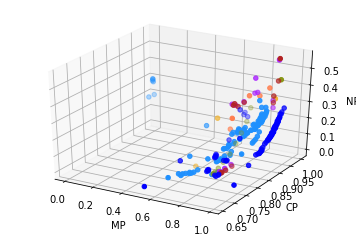

In [40]:
ax = plot_3d(evals_bacteria, 'MP', 'CP', 'NP')

In [46]:
devstats = set_threshold(evals_bacteria, 0.94, 0.95, 0.25, 'MP', 'CP', 'NP')
devstats.drop('naive-bayes-bespoke', level='Method')

,,Mock,MP,MR,Cross-validated,CP,CR,Novel taxa,NP,NR
Method,Parameters,,,,,,,,,
rdp,1.0,0.238734,0.94148,0.160176,0.631836,0.967903,0.46902,0.119826,0.456599,0.069022


In [207]:
set_threshold(evals_bacteria_precision, 0.95, 0.95, 0.25, 'MP', 'CP', 'NP')

Mock        MP        MR  \
Method              Parameters                                        
naive-bayes-bespoke 0.001::[6,6]:0.98  0.675678  0.986527  0.536697   
                    0.001::[7,7]:0.98  0.686757  0.979764  0.551431   

                                       Cross-validated        CP        CR  \
Method              Parameters                                               
naive-bayes-bespoke 0.001::[6,6]:0.98         0.802879  0.956260  0.691946   
                    0.001::[7,7]:0.98         0.814673  0.950889  0.712628   

                                       Novel taxa        NP        NR  
Method              Parameters                                         
naive-bayes-bespoke 0.001::[6,6]:0.98    0.162814  0.302948  0.111437  
                    0.001::[7,7]:0.98    0.163697  0.282534  0.115344

#### "high-recall" metric

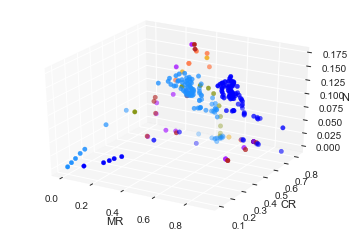

In [183]:
ax = plot_3d(evals_bacteria, 'MR', 'CR', 'NR')

In [54]:
devstats = set_threshold(evals_bacteria, 0.47, 0.75, 0.04, 'MR', 'CR', 'NR')
devstats.drop('naive-bayes-bespoke', level='Method')

Mock        MP        MR  Cross-validated  \
Method      Parameters                                                         
naive-bayes 0.001:[11,11]:0.5  0.566672  0.769775  0.479321         0.793152   
            0.001:[12,12]:0.5  0.566568  0.768982  0.479167         0.789864   
            0.001:[18,18]:0.5  0.564443  0.764473  0.477282         0.778949   
rdp         0.5                0.577373  0.791146  0.480373         0.816427   

                                     CP        CR  Novel taxa        NP  \
Method      Parameters                                                    
naive-bayes 0.001:[11,11]:0.5  0.819861  0.768136    0.059492  0.064847   
            0.001:[12,12]:0.5  0.816241  0.765146    0.059117  0.064195   
            0.001:[18,18]:0.5  0.806590  0.753145    0.056531  0.063004   
rdp         0.5                0.847648  0.787429    0.068071  0.078844   

                                     NR  
Method      Parameters                   
naive-bayes 0.001:[11,11]:0.5  0.054956  
            0.001:[12,12]:0.5  0.054786  
            0.001:[18,18]:0.5  0.051267  
rdp         0.5                0.059896

In [185]:
set_threshold(evals_bacteria, 0.7, 0.75, 0.04, 'MR', 'CR', 'NR')

Mock        MP        MR  \
Method              Parameters                                         
naive-bayes-bespoke 0.001::[12,12]:0.5  0.754058  0.800459  0.721253   
                    0.001::[14,14]:0.5  0.757531  0.801674  0.725593   
                    0.001::[16,16]:0.5  0.755331  0.784999  0.731651   
                    0.001::[18,18]:0.5  0.772246  0.802810  0.747975   
                    0.001::[32,32]:0.5  0.936868  0.966365  0.913330   

                                        Cross-validated        CP        CR  \
Method              Parameters                                                
naive-bayes-bespoke 0.001::[12,12]:0.5         0.815240  0.829910  0.801085   
                    0.001::[14,14]:0.5         0.811291  0.826325  0.796796   
                    0.001::[16,16]:0.5         0.808282  0.824839  0.792382   
                    0.001::[18,18]:0.5         0.805482  0.822705  0.788969   
                    0.001::[32,32]:0.5         0.787882  0.817525  0.760322   

                                        Novel taxa        NP        NR  \
Method              Parameters                                           
naive-bayes-bespoke 0.001::[12,12]:0.5    0.053206  0.057727  0.049344   
                    0.001::[14,14]:0.5    0.051823  0.056571  0.047813   
                    0.001::[16,16]:0.5    0.052220  0.057992  0.047495   
                    0.001::[18,18]:0.5    0.055136  0.061230  0.050147   
                    0.001::[32,32]:0.5    0.053593  0.066694  0.044801   

                                             sum  
Method              Parameters                    
naive-bayes-bespoke 0.001::[12,12]:0.5  1.622504  
                    0.001::[14,14]:0.5  1.620645  
                    0.001::[16,16]:0.5  1.615833  
                    0.001::[18,18]:0.5  1.632863  
                    0.001::[32,32]:0.5  1.778343

## Fungi level 6

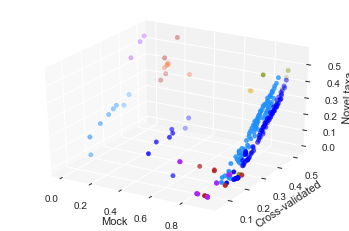

In [186]:
evals_fungi = combined_evaluation(
    mock_results, cv_results, nt_results, params,
    metric, method, reference, dataset, "fungi", level)

ax = plot_3d(evals_fungi)

ax.get_figure().savefig(join(outdir, "3way-eval-fmeasure-fungi.pdf"), facecolor="white")
ax.get_figure().savefig(join(outdir, "3way-eval-fmeasure-fungi.png"), facecolor="white")


In [187]:
# find top-performing methods across all evals
evals_fungi['sum'] = evals_fungi['Mock'] + evals_fungi['Cross-validated'] + evals_fungi['Novel taxa']
evals_fungi.sort_values('sum', ascending=False)[:10]

Mock        MP        MR  \
Method              Parameters                                        
rdp                 0.9                0.921991  0.937464  0.913311   
                    0.8                0.923891  0.938904  0.915099   
naive-bayes-bespoke 0.001::[6,6]:0.98  0.927422  0.969632  0.913376   
                    0.001::[6,6]:0.96  0.928001  0.967761  0.914569   
                    0.001::[7,7]:0.98  0.935468  0.969632  0.920564   
naive-bayes         0.001:[6,6]:0.98   0.874227  0.935085  0.827294   
rdp                 0.7                0.928929  0.939035  0.921740   
naive-bayes-bespoke 0.001::[6,6]:0.94  0.928001  0.967761  0.914569   
naive-bayes         0.001:[6,6]:0.96   0.874227  0.935085  0.827294   
naive-bayes-bespoke 0.001::[8,8]:0.98  0.929588  0.969632  0.915164   

                                       Cross-validated        CP        CR  \
Method              Parameters                                               
rdp                 0.9                       0.517324  0.697787  0.411087   
                    0.8                       0.506592  0.632788  0.422421   
naive-bayes-bespoke 0.001::[6,6]:0.98         0.503559  0.623920  0.422237   
                    0.001::[6,6]:0.96         0.490756  0.589913  0.420222   
                    0.001::[7,7]:0.98         0.486725  0.595609  0.411555   
naive-bayes         0.001:[6,6]:0.98          0.505361  0.628796  0.422549   
rdp                 0.7                       0.479447  0.571528  0.413002   
naive-bayes-bespoke 0.001::[6,6]:0.94         0.479764  0.566541  0.416102   
naive-bayes         0.001:[6,6]:0.96          0.494723  0.596504  0.422691   
naive-bayes-bespoke 0.001::[8,8]:0.98         0.471443  0.581775  0.396335   

                                       Novel taxa        NP        NR  \
Method              Parameters                                          
rdp                 0.9                  0.469883  0.617385  0.379322   
                    0.8                  0.434051  0.534094  0.365651   
naive-bayes-bespoke 0.001::[6,6]:0.98    0.420927  0.511613  0.357635   
                    0.001::[6,6]:0.96    0.393342  0.466027  0.340323   
                    0.001::[7,7]:0.98    0.385708  0.465972  0.329082   
naive-bayes         0.001:[6,6]:0.98     0.426155  0.519976  0.361091   
rdp                 0.7                  0.382254  0.451244  0.331614   
naive-bayes-bespoke 0.001::[6,6]:0.94    0.371032  0.432679  0.324801   
naive-bayes         0.001:[6,6]:0.96     0.398585  0.473223  0.344329   
naive-bayes-bespoke 0.001::[8,8]:0.98    0.365760  0.448802  0.308699   

                                            sum  
Method              Parameters                   
rdp                 0.9                1.909198  
                    0.8                1.864534  
naive-bayes-bespoke 0.001::[6,6]:0.98  1.851908  
                    0.001::[6,6]:0.96  1.812099  
                    0.001::[7,7]:0.98  1.807900  
naive-bayes         0.001:[6,6]:0.98   1.805743  
rdp                 0.7                1.790630  
naive-bayes-bespoke 0.001::[6,6]:0.94  1.778797  
naive-bayes         0.001:[6,6]:0.96   1.767535  
naive-bayes-bespoke 0.001::[8,8]:0.98  1.766792

In [188]:
set_threshold(evals_fungi, 0.85, 0.45, 0.37)


Mock        MP        MR  \
Method              Parameters                                        
naive-bayes         0.001:[6,6]:0.94   0.874227  0.935085  0.827294   
                    0.001:[6,6]:0.96   0.874227  0.935085  0.827294   
                    0.001:[6,6]:0.98   0.874227  0.935085  0.827294   
                    0.001:[7,7]:0.98   0.874227  0.935085  0.827294   
naive-bayes-bespoke 0.001::[6,6]:0.94  0.928001  0.967761  0.914569   
                    0.001::[6,6]:0.96  0.928001  0.967761  0.914569   
                    0.001::[6,6]:0.98  0.927422  0.969632  0.913376   
                    0.001::[7,7]:0.98  0.935468  0.969632  0.920564   
rdp                 0.7                0.928929  0.939035  0.921740   
                    0.8                0.923891  0.938904  0.915099   
                    0.9                0.921991  0.937464  0.913311   

                                       Cross-validated        CP        CR  \
Method              Parameters                                               
naive-bayes         0.001:[6,6]:0.94          0.480940  0.570173  0.415902   
                    0.001:[6,6]:0.96          0.494723  0.596504  0.422691   
                    0.001:[6,6]:0.98          0.505361  0.628796  0.422549   
                    0.001:[7,7]:0.98          0.485003  0.596209  0.408806   
naive-bayes-bespoke 0.001::[6,6]:0.94         0.479764  0.566541  0.416102   
                    0.001::[6,6]:0.96         0.490756  0.589913  0.420222   
                    0.001::[6,6]:0.98         0.503559  0.623920  0.422237   
                    0.001::[7,7]:0.98         0.486725  0.595609  0.411555   
rdp                 0.7                       0.479447  0.571528  0.413002   
                    0.8                       0.506592  0.632788  0.422421   
                    0.9                       0.517324  0.697787  0.411087   

                                       Novel taxa        NP        NR  \
Method              Parameters                                          
naive-bayes         0.001:[6,6]:0.94     0.374248  0.437836  0.326823   
                    0.001:[6,6]:0.96     0.398585  0.473223  0.344329   
                    0.001:[6,6]:0.98     0.426155  0.519976  0.361091   
                    0.001:[7,7]:0.98     0.387674  0.470084  0.329893   
naive-bayes-bespoke 0.001::[6,6]:0.94    0.371032  0.432679  0.324801   
                    0.001::[6,6]:0.96    0.393342  0.466027  0.340323   
                    0.001::[6,6]:0.98    0.420927  0.511613  0.357635   
                    0.001::[7,7]:0.98    0.385708  0.465972  0.329082   
rdp                 0.7                  0.382254  0.451244  0.331614   
                    0.8                  0.434051  0.534094  0.365651   
                    0.9                  0.469883  0.617385  0.379322   

                                            sum  
Method              Parameters                   
naive-bayes         0.001:[6,6]:0.94   1.729415  
                    0.001:[6,6]:0.96   1.767535  
                    0.001:[6,6]:0.98   1.805743  
                    0.001:[7,7]:0.98   1.746904  
naive-bayes-bespoke 0.001::[6,6]:0.94  1.778797  
                    0.001::[6,6]:0.96  1.812099  
                    0.001::[6,6]:0.98  1.851908  
                    0.001::[7,7]:0.98  1.807900  
rdp                 0.7                1.790630  
                    0.8                1.864534  
                    0.9                1.909198

#### "novel" fungi

In [198]:
set_threshold(evals_fungi, 0.85, 0.45, 0.4)


Mock        MP        MR  \
Method              Parameters                                        
naive-bayes         0.001:[6,6]:0.98   0.874227  0.935085  0.827294   
naive-bayes-bespoke 0.001::[6,6]:0.98  0.927422  0.969632  0.913376   
rdp                 0.8                0.923891  0.938904  0.915099   
                    0.9                0.921991  0.937464  0.913311   

                                       Cross-validated        CP        CR  \
Method              Parameters                                               
naive-bayes         0.001:[6,6]:0.98          0.505361  0.628796  0.422549   
naive-bayes-bespoke 0.001::[6,6]:0.98         0.503559  0.623920  0.422237   
rdp                 0.8                       0.506592  0.632788  0.422421   
                    0.9                       0.517324  0.697787  0.411087   

                                       Novel taxa        NP        NR  \
Method              Parameters                                          
naive-bayes         0.001:[6,6]:0.98     0.426155  0.519976  0.361091   
naive-bayes-bespoke 0.001::[6,6]:0.98    0.420927  0.511613  0.357635   
rdp                 0.8                  0.434051  0.534094  0.365651   
                    0.9                  0.469883  0.617385  0.379322   

                                            sum  
Method              Parameters                   
naive-bayes         0.001:[6,6]:0.98   1.805743  
naive-bayes-bespoke 0.001::[6,6]:0.98  1.851908  
rdp                 0.8                1.864534  
                    0.9                1.909198

## fungi level 5

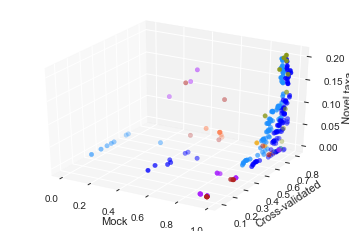

In [189]:
evals_fungi_5 = combined_evaluation(
    mock_results, cv_results, nt_results, params,
    metric, method, reference, dataset, "fungi", 5)

ax = plot_3d(evals_fungi_5)

ax.get_figure().savefig(join(outdir, "3way-eval-fmeasure-fungi-genus.pdf"), facecolor="white")
ax.get_figure().savefig(join(outdir, "3way-eval-fmeasure-fungi-genus.png"), facecolor="white")


In [190]:
# find top-performing methods across all evals
evals_fungi_5['sum'] = evals_fungi_5['Mock'] + evals_fungi_5['Cross-validated'] + evals_fungi_5['Novel taxa']
evals_fungi_5.sort_values('sum', ascending=False)[:10]

Mock        MP        MR  \
Method              Parameters                                        
naive-bayes-bespoke 0.001::[6,6]:0.9   0.976119  0.978335  0.974026   
rdp                 0.7                0.945432  0.952343  0.939870   
naive-bayes-bespoke 0.001::[6,6]:0.92  0.973070  0.978335  0.968625   
                    0.001::[6,6]:0.96  0.951815  0.974554  0.938709   
rdp                 0.6                0.945432  0.952343  0.939870   
naive-bayes-bespoke 0.001::[6,6]:0.98  0.951656  0.976425  0.937516   
                    0.001::[6,6]:0.94  0.952342  0.974645  0.939332   
                    0.001::[7,7]:0.94  0.964635  0.978084  0.954355   
                    0.001::[7,7]:0.92  0.964635  0.978084  0.954355   
                    0.001::[7,7]:0.96  0.957556  0.976437  0.944811   

                                       Cross-validated        CP        CR  \
Method              Parameters                                               
naive-bayes-bespoke 0.001::[6,6]:0.9          0.807002  0.894473  0.735173   
rdp                 0.7                       0.800292  0.909914  0.714317   
naive-bayes-bespoke 0.001::[6,6]:0.92         0.804963  0.897337  0.729907   
                    0.001::[6,6]:0.96         0.799349  0.909041  0.713373   
rdp                 0.6                       0.804966  0.890161  0.734724   
naive-bayes-bespoke 0.001::[6,6]:0.98         0.793017  0.919943  0.696984   
                    0.001::[6,6]:0.94         0.803522  0.903482  0.723560   
                    0.001::[7,7]:0.94         0.801875  0.901592  0.722092   
                    0.001::[7,7]:0.92         0.802857  0.896271  0.727167   
                    0.001::[7,7]:0.96         0.797888  0.907133  0.712213   

                                       Novel taxa        NP        NR  \
Method              Parameters                                          
naive-bayes-bespoke 0.001::[6,6]:0.9     0.167779  0.264073  0.123014   
rdp                 0.7                  0.204957  0.361206  0.143175   
naive-bayes-bespoke 0.001::[6,6]:0.92    0.172631  0.278470  0.125174   
                    0.001::[6,6]:0.96    0.191751  0.333218  0.134727   
rdp                 0.6                  0.191987  0.303091  0.140572   
naive-bayes-bespoke 0.001::[6,6]:0.98    0.197387  0.367639  0.135040   
                    0.001::[6,6]:0.94    0.181770  0.302628  0.130005   
                    0.001::[7,7]:0.94    0.166973  0.282415  0.118596   
                    0.001::[7,7]:0.92    0.165409  0.270620  0.119170   
                    0.001::[7,7]:0.96    0.174487  0.306682  0.122016   

                                            sum  
Method              Parameters                   
naive-bayes-bespoke 0.001::[6,6]:0.9   1.950900  
rdp                 0.7                1.950681  
naive-bayes-bespoke 0.001::[6,6]:0.92  1.950663  
                    0.001::[6,6]:0.96  1.942915  
rdp                 0.6                1.942385  
naive-bayes-bespoke 0.001::[6,6]:0.98  1.942060  
                    0.001::[6,6]:0.94  1.937634  
                    0.001::[7,7]:0.94  1.933482  
                    0.001::[7,7]:0.92  1.932900  
                    0.001::[7,7]:0.96  1.929931

#### "high-precision" fungi

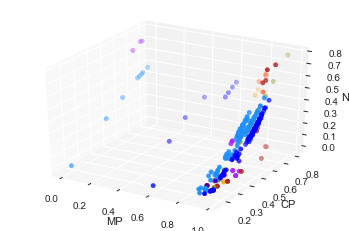

In [191]:
ax = plot_3d(evals_fungi, 'MP', 'CP', 'NP')

In [205]:
set_threshold(evals_fungi, 0.92, 0.6, 0.3, 'MP', 'CP', 'NP')


Mock        MP        MR  \
Method              Parameters                                        
naive-bayes         0.001:[6,6]:0.98   0.874227  0.935085  0.827294   
naive-bayes-bespoke 0.001::[6,6]:0.98  0.927422  0.969632  0.913376   
rdp                 0.8                0.923891  0.938904  0.915099   
                    0.9                0.921991  0.937464  0.913311   
                    1.0                0.821206  0.942963  0.742323   

                                       Cross-validated        CP        CR  \
Method              Parameters                                               
naive-bayes         0.001:[6,6]:0.98          0.505361  0.628796  0.422549   
naive-bayes-bespoke 0.001::[6,6]:0.98         0.503559  0.623920  0.422237   
rdp                 0.8                       0.506592  0.632788  0.422421   
                    0.9                       0.517324  0.697787  0.411087   
                    1.0                       0.460527  0.809984  0.321902   

                                       Novel taxa        NP        NR  \
Method              Parameters                                          
naive-bayes         0.001:[6,6]:0.98     0.426155  0.519976  0.361091   
naive-bayes-bespoke 0.001::[6,6]:0.98    0.420927  0.511613  0.357635   
rdp                 0.8                  0.434051  0.534094  0.365651   
                    0.9                  0.469883  0.617385  0.379322   
                    1.0                  0.459469  0.774336  0.326800   

                                            sum  
Method              Parameters                   
naive-bayes         0.001:[6,6]:0.98   1.805743  
naive-bayes-bespoke 0.001::[6,6]:0.98  1.851908  
rdp                 0.8                1.864534  
                    0.9                1.909198  
                    1.0                1.741202

#### "high-recall" fungi

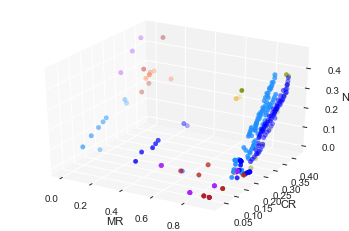

In [193]:
ax = plot_3d(evals_fungi, 'MR', 'CR', 'NR')

In [194]:
set_threshold(evals_fungi, 0.9, 0.4, 0.3, 'MR', 'CR', 'NR')


Mock        MP        MR  \
Method              Parameters                                        
naive-bayes-bespoke 0.001::[6,6]:0.92  0.937779  0.971207  0.923596   
                    0.001::[6,6]:0.94  0.928001  0.967761  0.914569   
                    0.001::[6,6]:0.96  0.928001  0.967761  0.914569   
                    0.001::[6,6]:0.98  0.927422  0.969632  0.913376   
                    0.001::[7,7]:0.96  0.935429  0.969407  0.920564   
                    0.001::[7,7]:0.98  0.935468  0.969632  0.920564   
rdp                 0.7                0.928929  0.939035  0.921740   
                    0.8                0.923891  0.938904  0.915099   
                    0.9                0.921991  0.937464  0.913311   

                                       Cross-validated        CP        CR  \
Method              Parameters                                               
naive-bayes-bespoke 0.001::[6,6]:0.92         0.466855  0.544321  0.408755   
                    0.001::[6,6]:0.94         0.479764  0.566541  0.416102   
                    0.001::[6,6]:0.96         0.490756  0.589913  0.420222   
                    0.001::[6,6]:0.98         0.503559  0.623920  0.422237   
                    0.001::[7,7]:0.96         0.469653  0.560104  0.404420   
                    0.001::[7,7]:0.98         0.486725  0.595609  0.411555   
rdp                 0.7                       0.479447  0.571528  0.413002   
                    0.8                       0.506592  0.632788  0.422421   
                    0.9                       0.517324  0.697787  0.411087   

                                       Novel taxa        NP        NR  \
Method              Parameters                                          
naive-bayes-bespoke 0.001::[6,6]:0.92    0.352976  0.407110  0.311591   
                    0.001::[6,6]:0.94    0.371032  0.432679  0.324801   
                    0.001::[6,6]:0.96    0.393342  0.466027  0.340323   
                    0.001::[6,6]:0.98    0.420927  0.511613  0.357635   
                    0.001::[7,7]:0.96    0.357488  0.422168  0.310035   
                    0.001::[7,7]:0.98    0.385708  0.465972  0.329082   
rdp                 0.7                  0.382254  0.451244  0.331614   
                    0.8                  0.434051  0.534094  0.365651   
                    0.9                  0.469883  0.617385  0.379322   

                                            sum  
Method              Parameters                   
naive-bayes-bespoke 0.001::[6,6]:0.92  1.757609  
                    0.001::[6,6]:0.94  1.778797  
                    0.001::[6,6]:0.96  1.812099  
                    0.001::[6,6]:0.98  1.851908  
                    0.001::[7,7]:0.96  1.762570  
                    0.001::[7,7]:0.98  1.807900  
rdp                 0.7                1.790630  
                    0.8                1.864534  
                    0.9                1.909198

## Results from levels 2 through 6

<IPython.core.display.Javascript object>


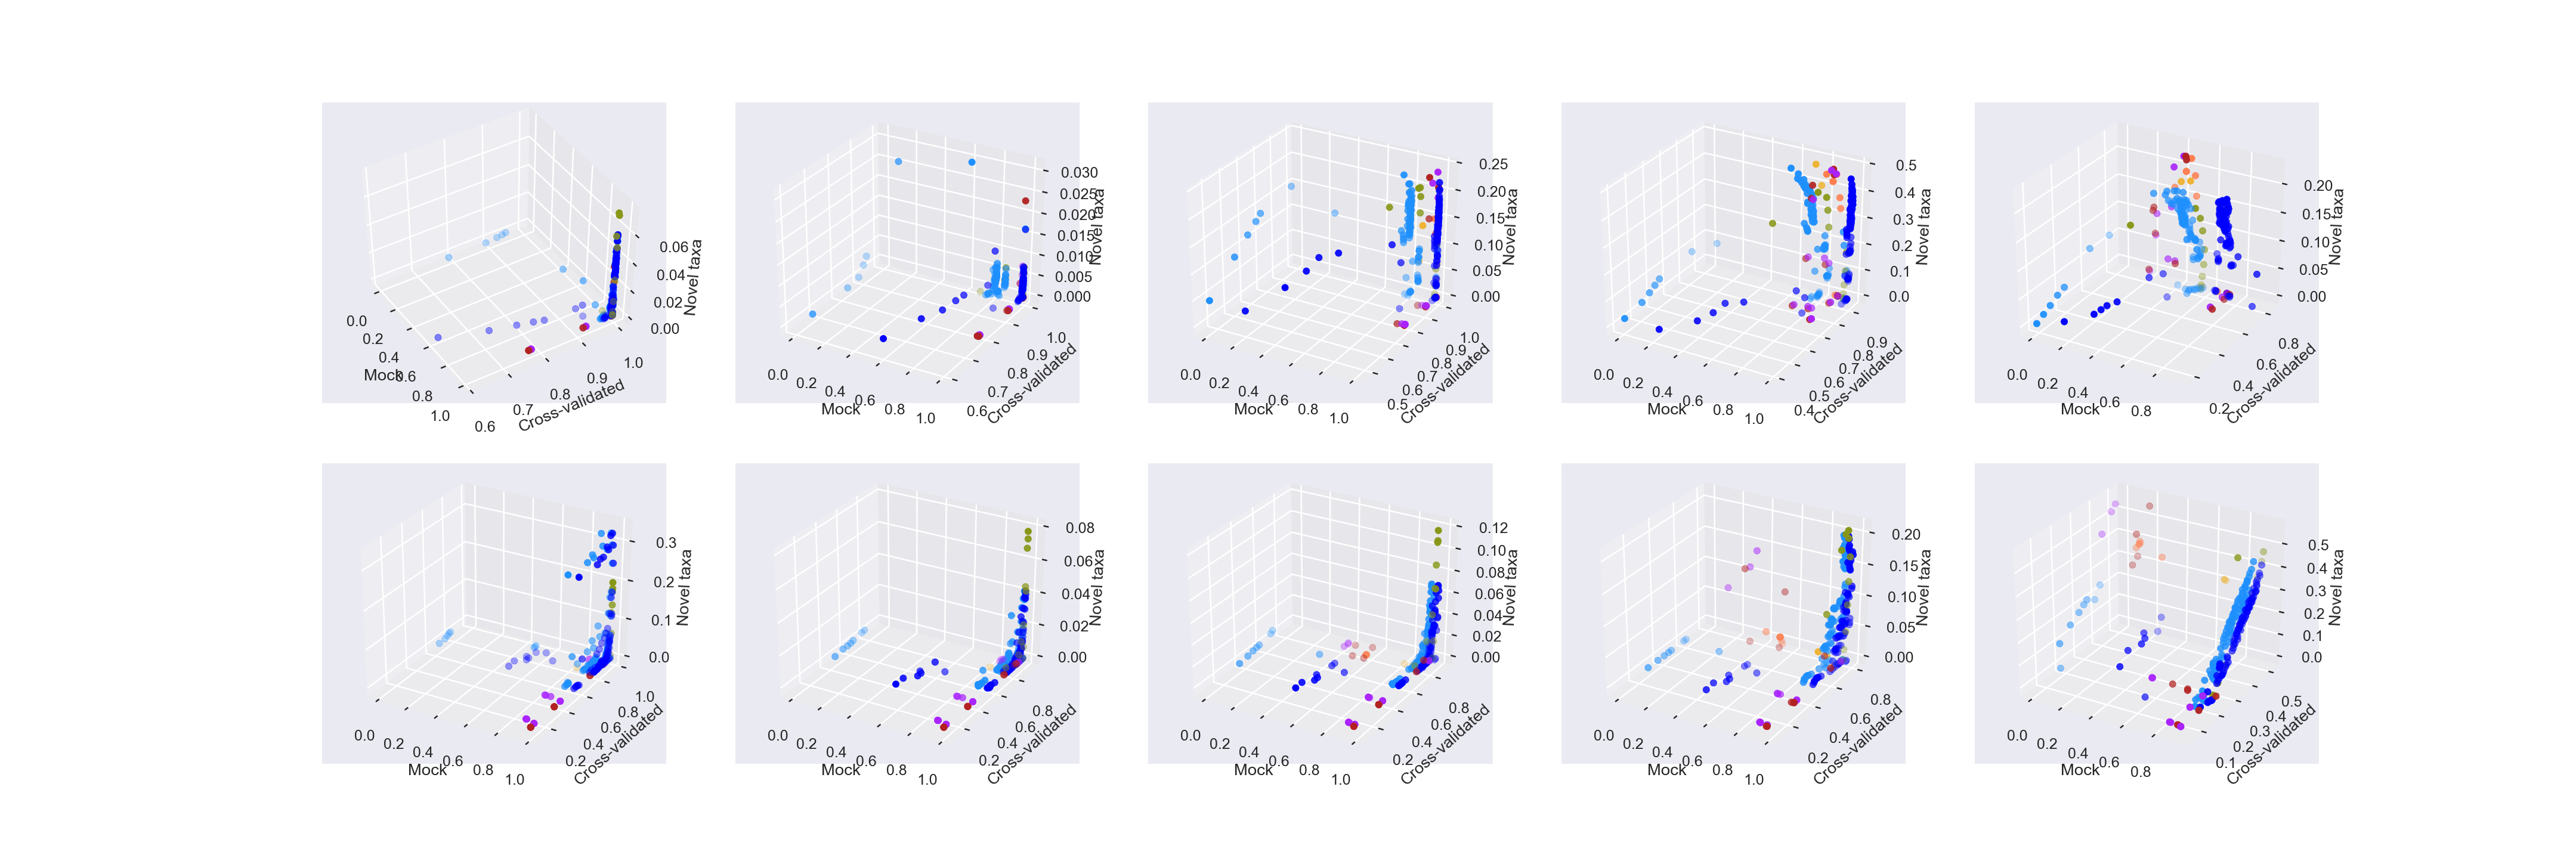

In [26]:
p = plt.figure(figsize=(24, 8))
c = 0
for d in ["bacteria", "fungi"]:
    if d == "fungi":
        c = 5
    for l in range(2,7):
        evals_combined = combined_evaluation(
        mock_results, cv_results, nt_results, params,
        metric, method, reference, dataset, d, l)

        #p = plt.subplot(5, 2, l-1)
        #ax = p.gca(projection='3d')
        ax = p.add_subplot(2, 5, l-1+c, projection='3d')
        for m in evals_combined.index.levels[0]:
            evals_subset = evals_combined.loc[m]
            ax.scatter(xs=evals_subset['Mock'],
                       ys=evals_subset['Cross-validated'],
                       zs=evals_subset['Novel taxa'],
                       c=color_palette[m])

        ax.set_xlabel('Mock')
        ax.set_ylabel('Cross-validated')
        ax.set_zlabel('Novel taxa')

plt.show()


## precision, recall, and f-measure

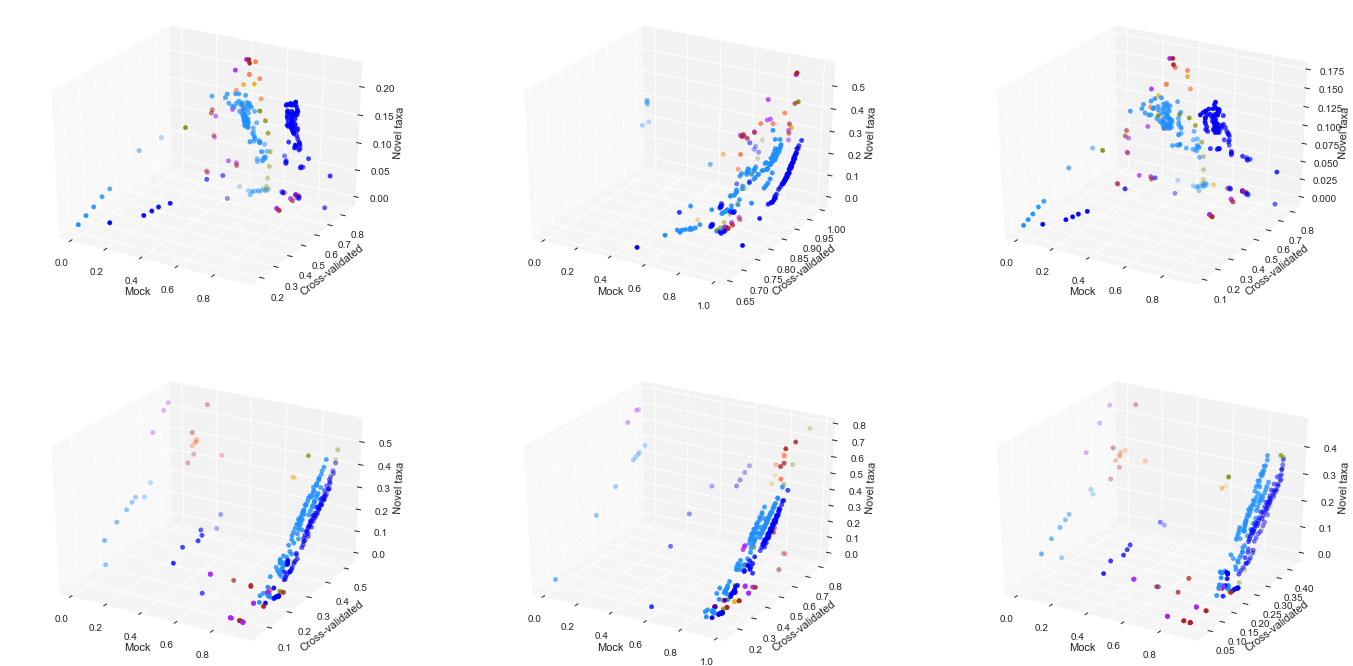

In [40]:
p = plt.figure(figsize=(24, 12))
c = 0
p.set_facecolor('white')
for d in ["bacteria", "fungi"]:
    if d == "fungi":
        c = 3
    for metric in ['F-measure', 'Precision', 'Recall']:
        evals_combined = combined_evaluation(
            mock_results, cv_results, nt_results, params,
            metric, method, reference, dataset, d, 6)
        c+=1

        ax = p.add_subplot(2, 3, c, projection='3d')
        ax.set_facecolor('white')
        for m in evals_combined.index.levels[0]:
            evals_subset = evals_combined.loc[m]
            ax.scatter(xs=evals_subset['Mock'],
                       ys=evals_subset['Cross-validated'],
                       zs=evals_subset['Novel taxa'],
                       c=color_palette[m])

        ax.set_xlabel('Mock')
        ax.set_ylabel('Cross-validated')
        ax.set_zlabel('Novel taxa')

plt.show()


In [41]:
p.savefig(join(outdir, "3way-eval.png"), facecolor="white")
p.savefig(join(outdir, "3way-eval.pdf"), facecolor="white")